In [ ]:
# -*- coding: utf-8 -*-
"""
This script contains all the necessary imports for a deep learning project
focused on image classification, evaluation, and explainability using PyTorch.
"""

# --- Standard Library Imports ---
import logging
import os
import random

# --- Third-party Library Imports ---

# For numerical operations
import numpy as np

# For image processing and computer vision tasks
import cv2
from PIL import Image

# For data visualization and plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning metrics and preprocessing
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    cohen_kappa_score, mean_squared_error, mean_absolute_error,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize

# Core PyTorch library for deep learning
import torch
import torch.backends.cudnn as cudnn
import torch.hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch utilities for data handling and transformations
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms

# For creating progress bars for loops
from tqdm import tqdm

In [ ]:
# Configure basic logging to capture only ERROR level messages and above.
# This helps in debugging issues related to data loading without cluttering
# the console with less critical information.
# Format: Timestamp - Log Level - Log Message
logging.basicConfig(
    level=logging.ERROR, 
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class RetinalDataset(Dataset):
    """
    Custom PyTorch Dataset for loading retinal images.

    This class assumes a directory structure where each subdirectory in `data_dir`
    is named with an integer class label (e.g., '0', '1', '2'), and each
    subdirectory contains the corresponding images.

    Args:
        data_dir (str): The path to the root directory of the dataset.
        transform (callable, optional): A function/transform to apply to the images.
                                        Typically a `torchvision.transforms.Compose` object.
                                        Defaults to None.
    """
    def __init__(self, data_dir, transform=None):
        """
        Initializes the dataset by scanning the data directory and populating
        the lists of image paths and corresponding labels.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through each class folder, assuming folder names are integer labels.
        # Sorting ensures a consistent order.
        for class_label in sorted(os.listdir(data_dir)):
            class_dir = os.path.join(data_dir, class_label)

            # Process only if the path is a directory.
            if os.path.isdir(class_dir):
                # Iterate through each image file in the class directory.
                for img_name in os.listdir(class_dir):
                    # Consider only common image file extensions.
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(class_dir, img_name)
                        self.image_paths.append(img_path)
                        # Convert the folder name (class label) to an integer.
                        self.labels.append(int(class_label))
    
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        Required for the Dataset interface.
        """
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """
        Retrieves a single sample (image and label) from the dataset at the
        specified index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the transformed image and its integer label.
                   (image, label)

        Raises:
            Exception: Re-raises exceptions caught during image loading after logging
                       the error, which can be handled by the DataLoader.
        """
        img_path = self.image_paths[idx]
        try:
            # Open the image using PIL and convert to RGB to ensure a consistent 3-channel format.
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            # Apply the specified transformations (e.g., resizing, normalization, tensor conversion).
            if self.transform:
                image = self.transform(image)
            
            return image, label
            
        except Exception as e:
            # Log any error encountered while opening or processing an image.
            # This is crucial for identifying corrupted files in the dataset.
            logging.error(f"Error opening or processing image: {img_path}")
            # Re-raising the exception allows PyTorch's DataLoader to handle it,
            # for example by skipping the corrupt sample.
            raise e

In [ ]:
# =============================================================================
#                           CONFIGURATION & PATHS
# =============================================================================

# --- Main Data Paths ---
# A list of paths to directories, each containing a dataset for training.
# This setup allows for combining multiple data sources into one training set.
train_data_paths = [
    "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/3_DeepDRiD",
    "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/6_RLDR",
    "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/4_Messidor2",
    "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/5_FGADR",
    "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/1_IDRiD"
]

# Path to the single test dataset.
test_data_path = "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/2_APTOS"


# =============================================================================
#                      IMAGE TRANSFORMATIONS & PREPROCESSING
# =============================================================================

# ImageNet default mean and standard deviation, commonly used for transfer learning
# with models pre-trained on ImageNet. DINOv2 also uses these standard values.
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

# Transformation pipeline for the training dataset.
# Includes data augmentation to improve model generalization and reduce overfitting.
train_transform = transforms.Compose([
    transforms.Resize((504, 504)),  # Resize images to a fixed size.
    # Apply random horizontal flips with a 30% probability.
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.3),
    # Apply random rotations up to 5 degrees with a 20% probability.
    transforms.RandomApply([transforms.RandomRotation(5)], p=0.2),
    transforms.ToTensor(),  # Convert PIL Image to a PyTorch Tensor.
    # Normalize tensor with ImageNet mean and std.
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# Transformation pipeline for the validation and test datasets.
# No random augmentations are applied to ensure consistent and reproducible evaluation.
test_transform = transforms.Compose([
    transforms.Resize((504, 504)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])


# =============================================================================
#                     DATASET & DATALOADER PREPARATION
# =============================================================================

# --- Training & Validation Sets ---

# Create a list of `RetinalDataset` objects from the specified training paths.
train_datasets = []
for train_path in train_data_paths:
    if os.path.exists(train_path):  # Defensive check to ensure the path exists.
        train_datasets.append(RetinalDataset(train_path, transform=train_transform))
    else:
        print(f"Warning: Training path not found and skipped: {train_path}")

# Combine all individual training datasets into a single logical dataset.
# `ConcatDataset` is ideal for training on multiple data sources seamlessly.
full_train_dataset = ConcatDataset(train_datasets)

# Split the combined training dataset into training and validation sets.
# The validation set is used to monitor model performance on unseen data during training.
validation_split = 0.2
if len(full_train_dataset) > 0:
    train_size = int((1 - validation_split) * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
else:
    # Handle the edge case where no datasets were loaded.
    train_dataset, val_dataset = [], []
    train_size, val_size = 0, 0
    print("Warning: No training data loaded. Training and validation sets are empty.")

# Create DataLoaders for the training and validation sets.
# DataLoaders provide iterable batches of data, with options for shuffling,
# parallel loading, and memory pinning for GPU efficiency.
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, pin_memory=True, num_workers=4, drop_last=True) # drop_last avoids issues with batchnorm on the last, smaller batch

print(f"Total training samples: {train_size}")
print(f"Total validation samples: {val_size}")

# --- Test Set ---

# Create the test dataset from the specified path.
print("Constructing the test set.")
test_dataset = RetinalDataset(test_data_path, transform=test_transform)

# Create a DataLoader for the test set. Shuffling is set to False for consistent evaluation.
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, pin_memory=True, num_workers=4)
print(f"Total test samples: {len(test_dataset)}")


# =============================================================================
#                             MODEL PARAMETERS
# =============================================================================

# Dynamically determine the number of classes from the loaded dataset(s).
# This makes the script adaptable to datasets with different numbers of classes.
if train_datasets:
    all_labels = [label for ds in train_datasets for label in ds.labels]
    num_classes = len(set(all_labels))
else:
    num_classes = 0 # Default if no data is loaded.

print(f"Number of classes detected: {num_classes}")

Numero di campioni nel training set: 5889
Numero di campioni nel validation set: 1473
Numero di classi: 5


In [ ]:
# =============================================================================
#                  MODEL SETUP FOR FINE-TUNING DINOv2
#
# This script configures a pre-trained DINOv2 model for a downstream
# classification task. It involves:
# 1. Loading the giant Vision Transformer (ViT-G/14) DINOv2 model.
# 2. Implementing a partial fine-tuning strategy by freezing the initial
#    layers and unfreezing only the final transformer blocks.
# 3. Attaching a custom classification head to the DINOv2 backbone.
# =============================================================================

# Set the computation device to CUDA if a compatible GPU is available, otherwise use CPU.
# This is standard practice for deep learning to leverage GPU acceleration.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained DINOv2 model with a ViT-G/14 backbone using torch.hub.
# The `_reg` suffix indicates the model variant trained with registers.
print("Loading DINOv2 pre-trained backbone...")
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg').to(device)
print("Backbone loaded successfully.")

# --- Fine-Tuning Strategy: Partial Unfreezing ---

# 1. Freeze all parameters in the backbone by default.
# This prevents the pre-trained weights from being updated during the initial
# phase of training, preserving the powerful, general features learned by DINOv2.
for param in backbone.parameters():
    param.requires_grad = False

# 2. Unfreeze only the last few transformer blocks for fine-tuning.
# This allows the model to adapt its most high-level features to the specifics
# of the new dataset without suffering from catastrophic forgetting.
# The block indices (35-39) are chosen as they are the final layers of the ViT-G model.
print("Unfreezing final layers of the backbone for fine-tuning...")
for name, param in backbone.named_parameters():
    # To inspect all layer names, uncomment the following line:
    # print(name)
    if any(b in name for b in ['blocks.35.', 'blocks.36.', 'blocks.37.', 'blocks.38.', 'blocks.39.']):
        param.requires_grad = True
        print(f"  - Unfroze layer: {name}")

class ClassificationHead(nn.Module):
    """
    A wrapper module that combines the DINOv2 backbone with a new classifier.

    This class handles the forward pass through the backbone, extracts the
    appropriate feature vector ([CLS] token), and passes it to a sequential
    classifier for the final prediction.

    Args:
        backbone (nn.Module): The pre-trained DINOv2 model.
        num_classes (int): The number of output classes for the classification task.
    """
    def __init__(self, backbone, num_classes=5):
        super(ClassificationHead, self).__init__()
        self.backbone = backbone
        
        # The feature dimension of the DINOv2 ViT-G/14 model output.
        feature_dim = 1536
        
        # Define a simple MLP (Multi-Layer Perceptron) as the classifier.
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),  # Input layer from backbone feature dim
            nn.ReLU(),                    # Activation function for non-linearity
            nn.Dropout(0.3),              # Dropout for regularization to prevent overfitting
            nn.Linear(512, num_classes)   # Output layer mapping to the number of classes
        )
    
    def forward(self, x):
        """
        Defines the forward pass of the model.
        
        Args:
            x (torch.Tensor): The input batch of images.
            
        Returns:
            torch.Tensor: The output logits from the classifier.
        """
        # Get the feature embeddings from the DINOv2 backbone.
        features = self.backbone(x)
        
        # DINOv2's output format can vary. This block robustly extracts the
        # CLS token embedding, which is the standard representation for classification.
        if isinstance(features, dict) and "x_norm_clstoken" in features:
            # Handles output from models trained with registers.
            features_cls = features["x_norm_clstoken"]
        elif isinstance(features, tuple):
            # Assumes the first element of a tuple output is the CLS token.
            features_cls = features[0]
        else:
            # Fallback for when the backbone returns a raw tensor directly.
            features_cls = features
        
        # Pass the extracted CLS token through the custom classifier.
        return self.classifier(features_cls)

Using cache found in /home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main
/home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [ ]:
# =============================================================================
#                           REPRODUCIBILITY SETUP
# =============================================================================
# Set a fixed seed for random number generators to ensure that results are
# reproducible across different runs. This is crucial for experimental consistency.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Optional CuDNN settings for full determinism.
# Note: This can sometimes impact performance but guarantees identical results.
cudnn.deterministic = True


# =============================================================================
#                           MAIN TRAINING FUNCTION
# =============================================================================

def train_model(train_loader, val_loader, resume=False):
    """
    Trains and validates a deep learning model.

    This function encapsulates the entire training pipeline, including:
    - Setting up the model, optimizer, and loss function.
    - An epoch-based training and validation loop.
    - A checkpointing system to save and resume training state.
    - Early stopping to prevent overfitting.
    - Logging and plotting of key performance metrics.

    Args:
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        resume (bool): If True, attempts to resume training from the last checkpoint.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # --- Training Hyperparameters ---
    num_classes = 5
    num_epochs = 60
    patience = 5  # Patience for early stopping
    
    # --- Checkpoint Configuration ---
    checkpoint_dir = '/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Checkpoint_training/'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # --- Model, Optimizer, and Loss Function ---
    model = ClassificationHead(backbone, num_classes=num_classes).to(device)
    
    # Define the optimizer with differential learning rates.
    # The pre-trained backbone uses a very low learning rate to avoid disrupting
    # its learned features, while the new classifier head uses a higher one.
    optimizer = optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': 1e-6},  # Low LR for the backbone
        {'params': model.classifier.parameters(), 'lr': 1e-3} # Higher LR for the new head
    ])
    
    # Standard loss function for multi-class classification.
    criterion = nn.CrossEntropyLoss()

    # --- State Tracking Variables ---
    best_val_loss = float('inf')
    best_accuracy = 0.0
    patience_counter = 0
    start_epoch = 0
    
    # Dictionary to store metrics history for plotting later.
    history = {
        'train_loss': [], 'val_loss': [], 'accuracy': [],
        'f1_macro': [], 'auc': []
    }
    
    # --- Resume from Checkpoint Logic ---
    latest_checkpoint_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')

    if resume and os.path.exists(latest_checkpoint_path):
        print(f"Resuming training from checkpoint: {latest_checkpoint_path}")
        # Load the checkpoint. map_location ensures it loads correctly on the current device.
        checkpoint = torch.load(latest_checkpoint_path, map_location=device)
        
        # Restore the state of the model and optimizer.
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Restore all tracking variables to continue seamlessly.
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        best_accuracy = checkpoint['best_accuracy']
        patience_counter = checkpoint['patience_counter']
        history = checkpoint['history']
        
        print(f"Resumed from epoch {start_epoch}. Best validation loss so far: {best_val_loss:.4f}")
    else:
        if resume:
            print(f"Resume requested, but no checkpoint found at {latest_checkpoint_path}. Starting from scratch.")
        else:
            print("Starting training from scratch.")

    # ========================================================= #
    #                       TRAINING LOOP
    # ========================================================= #
    for epoch in range(start_epoch, num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        # Use tqdm for a descriptive progress bar
        for images, labels in tqdm(train_loader, desc=f"Training epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()      # Clear previous gradients
            outputs = model(images)    # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward()            # Backward pass (compute gradients)
            optimizer.step()           # Update weights
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        history['train_loss'].append(train_loss)
        
        print(f"\n[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}")
        
        # --- Validation Phase ---
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        all_preds, all_labels, all_probs = [], [], []
        
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
                
                # Store predictions and labels for metric calculation
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probabilities.cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader)
        history['val_loss'].append(val_loss)
        
        # --- Calculate Validation Metrics ---
        all_labels, all_preds, all_probs = np.array(all_labels), np.array(all_preds), np.array(all_probs)
        
        accuracy_val = accuracy_score(all_labels, all_preds)
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        
        # Binarize labels for multi-class AUC calculation (One-vs-Rest)
        all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        auc_val = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')
        
        history['accuracy'].append(accuracy_val)
        history['f1_macro'].append(f1_macro)
        history['auc'].append(auc_val)
        
        print(f"Validation -> Loss: {val_loss:.4f} | Accuracy: {accuracy_val:.4f} | F1 Macro: {f1_macro:.4f} | AUC: {auc_val:.4f}")
        
        # Update historical best accuracy
        best_accuracy = max(accuracy_val, best_accuracy)

        # --- Early Stopping & Best Model Saving ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the model state dict that achieved the best validation loss
            torch.save(model.state_dict(), 'best_dinov2_model.pth')
            print(f"-> New best validation loss. Model saved ({best_val_loss:.4f}).")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break  # Exit the training loop
        
        # --- Save Checkpoint After Each Epoch ---
        checkpoint_data = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_accuracy': best_accuracy,
            'patience_counter': patience_counter,
            'history': history
        }
        # Overwrite the latest checkpoint file for easy resumption
        torch.save(checkpoint_data, latest_checkpoint_path)

    # --- Post-Training Analysis ---
    print("\nTraining complete.")
    print(f"Best recorded accuracy: {best_accuracy:.4f}")
    print(f"Best recorded validation loss: {best_val_loss:.4f}")

    # --- Plotting Metrics ---
    plt.figure(figsize=(15, 10))
    plt.suptitle("Training & Validation Metrics Over Epochs", fontsize=16)

    # Plot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trend')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['accuracy'], label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Trend')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['f1_macro'], label='Validation F1 Macro', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Macro Trend')
    plt.legend()
    plt.grid(True)

    # Plot 4: AUC
    plt.subplot(2, 2, 4)
    plt.plot(history['auc'], label='Validation AUC', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC (One-vs-Rest) Trend')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.savefig('training_metrics.png')
    plt.show()

# =============================================================================
#                           EXECUTION BLOCK
# =============================================================================

# Prompt the user to decide whether to resume training.
flag = input("Resume training from the last checkpoint? (y/yes to resume): ")
resume_flag = flag.lower() in ["y", "yes"]
    
# Launch the training function.
train_model(train_loader, val_loader, resume=resume_flag)

Vuoi continuare l'addestramento o ripartire? (y/Yes/yes per continuare)  yes


Caricamento checkpoint...
Ripreso addestramento dall'epoca 14 (best_val_loss finora: 0.4376)


Training epoch 15/60: 100%|██████████| 1473/1473 [58:14<00:00,  2.37s/it]

[Epoca 15/60] Train Loss: 0.4167


Validation Loss: 0.4233 | Accuracy: 0.8322 | F1 Macro: 0.8294 | AUC: 0.9740
-> Miglior val_loss. Modello salvato (0.4233).


Training epoch 16/60:  17%|█▋        | 255/1473 [10:07<48:21,  2.38s/it]


KeyboardInterrupt: 

Using cache found in /home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_317431/3803465368.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mod

Risultati finali:
AUC: 0.8560 | Acc: 0.7484 | F1 Macro: 0.5221
Accuracy: 0.7484
F1 Macro: 0.5221
AUC: 0.8560
Cohen's Kappa: 0.7736


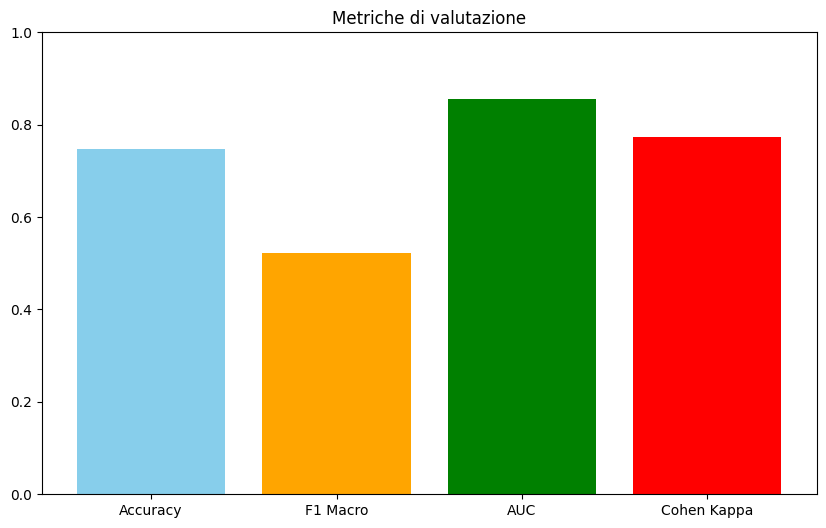

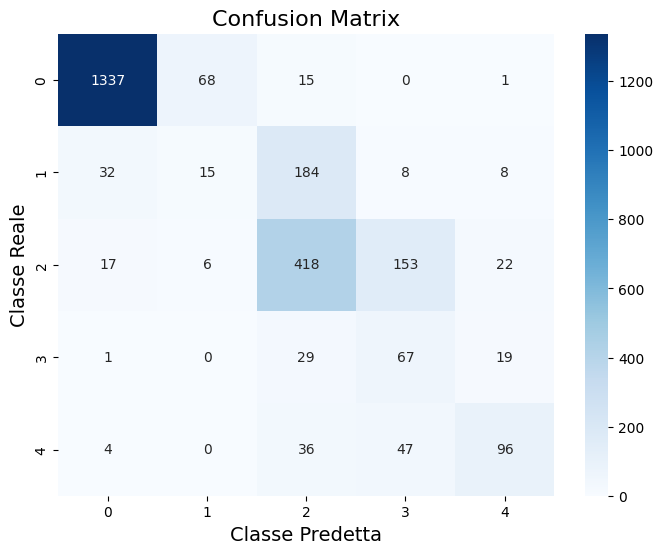

In [ ]:
# =============================================================================
#                        MODEL EVALUATION ON TEST SET
#
# This script loads the best-performing model checkpoint from the training
# phase and evaluates its performance on the unseen test dataset.
# It calculates and visualizes a comprehensive set of classification metrics,
# including a confusion matrix, to provide a final assessment of the model.
# =============================================================================

# --- 1. Model and Environment Setup ---

# Set the computation device (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-define the model architecture. The 'backbone' variable is assumed to be
# loaded and configured from the previous training context.
# The following line is for architecture definition, not for re-loading weights here.
torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg', force_reload=True).to(device)

# Instantiate the full model (backbone + classification head).
model = ClassificationHead(backbone, num_classes=5).to(device)

# Load the saved weights from the best model checkpoint.
# This file should contain the state_dict of the model that achieved the
# lowest validation loss during training.
print("Loading best model weights for evaluation...")
model.load_state_dict(torch.load('best_dinov2_model_con_preprocessing.pth'))

# Set the model to evaluation mode. This is crucial as it disables layers
# like Dropout and sets BatchNorm layers to use running statistics, ensuring
# deterministic output for inference.
model.eval()
print("Model loaded and set to evaluation mode.")


# --- 2. Inference on the Test Set ---
# Initialize lists to store the ground truth labels, model predictions,
# and output probabilities for later metric calculation.
all_preds = []
all_labels = []
all_probs = []

# `torch.no_grad()` context manager disables gradient calculation, which
# reduces memory consumption and speeds up inference significantly.
with torch.no_grad():
    # Iterate over the test_loader with a progress bar.
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        # Move data to the configured device.
        images, labels = images.to(device), labels.to(device)
        
        # Perform a forward pass to get model outputs (logits).
        outputs = model(images)
        
        # Convert logits to probabilities using softmax for AUC calculation.
        probabilities = torch.softmax(outputs, dim=1)
        
        # Get the predicted class index by finding the max logit.
        _, predicted = torch.max(outputs, 1)
        
        # Append results to the lists, moving them back to the CPU.
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())


# --- 3. Final Metrics Calculation ---
# Convert lists to NumPy arrays for efficient computation with scikit-learn.
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Calculate a suite of standard classification metrics.
accuracy_val = accuracy_score(all_labels, all_preds)
f1_macro = f1_score(all_labels, all_preds, average='macro')

# For multi-class AUC, binarize the labels and use the One-vs-Rest strategy.
num_classes = 5
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
auc = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')

# Cohen's Kappa is excellent for imbalanced classes and multi-class problems.
# 'linear' weighting is appropriate for ordinal data (where classes have an order).
cohen_kappa = cohen_kappa_score(all_labels, all_preds, weights='linear')

# Print a clear summary of the final results.
print("\n--- Final Test Set Results ---")
print(f"Accuracy:      {accuracy_val:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"AUC (OvR):       {auc:.4f}")
print(f"Cohen's Kappa (Linear): {cohen_kappa:.4f}")
print("----------------------------\n")


# --- 4. Results Visualization ---

# (a) Bar chart for a high-level overview of the key metrics.
plt.figure(figsize=(10, 6))
metrics_names = ['Accuracy', 'F1 Macro', 'AUC', 'Cohen Kappa']
metrics_values = [accuracy_val, f1_macro, auc, cohen_kappa]
bars = plt.bar(metrics_names, metrics_values, color=['#0077b6', '#f4a261', '#2a9d8f', '#e76f51'])
plt.title('Final Model Evaluation Metrics on Test Set', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1) # Set y-axis limit to be from 0 to 1.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars.
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center') # va: vertical alignment

plt.show()

# (b) Confusion Matrix for detailed error analysis.
# The matrix shows correct predictions on the diagonal and misclassifications
# on the off-diagonal elements, providing insight into which classes the
# model struggles to differentiate.
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(range(num_classes)),
            yticklabels=list(range(num_classes)))
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()